In [ ]:
# ============================
# By: Imam Cholissodin | imamcs@ub.ac.id
# Fakultas Ilmu Komputer (Filkom)
# Universitas Brawijaya (UB)
# Tgl 2 Juni 2020
# Semoga Bermanfaat. Aamiin :D
# ====================================

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
!pwd
#os.chdir("/content/drive/My Drive")
os.chdir("/")
!pwd
!ls

/content
/
bin					   etc	  opt	 sys
boot					   home   proc	 tensorflow-1.15.2
content					   lib	  root	 tmp
datalab					   lib32  run	 tools
dev					   lib64  sbin	 usr
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  media  srv	 var
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   mnt	  swift


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/spark-2.4.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark
!jps

548 Jps
479 SparkSubmit


In [ ]:
import pyspark
from pyspark.context import SparkContext
spark = SparkSession\
        .builder\
        .appName("Map Pada Spark")\
        .getOrCreate()
        
#sc = SparkContext.getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
def add1(x): 
    return x+5

raw_data = sc.parallelize([1,2,3])
rdd = raw_data.map(lambda x: add1(x))
#print(rdd.take(3))
print(rdd.collect())

[6, 7, 8]


In [ ]:
import numpy as np
print(np.random.random((3, 3, 3)))

[[[0.93651504 0.00278204 0.8130632 ]
  [0.17703447 0.19797448 0.54495279]
  [0.66867017 0.92630946 0.58698467]]

 [[0.21030781 0.101875   0.84145   ]
  [0.06659398 0.11719982 0.99990495]
  [0.086442   0.98147816 0.14909002]]

 [[0.15733057 0.49335758 0.81414777]
  [0.14962659 0.49545361 0.80379585]
  [0.60954818 0.36097737 0.37860973]]]


In [ ]:
#-------------- koding Batch SOM Algorithm ----------------------------#
# Bagian ini mengharuskan Anda untuk memiliki pengetahuan dasar tentang 
# Apache Spark dan konsep-konsep seperti map, reduce, broadcast, rdd,  dataframe, dll....
 
#import pyspark
from pyspark import SparkContext, Row, SQLContext
from pyspark.ml.linalg import Vectors

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

__author__ = 'topsykretts_ReCoverbyNidos'


def find_bmu(row_t, net):
        """
            Find the best matching unit for a given vector, row_t, in the SOM
            Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional Best Matching Unit
                     and bmu_idx is the index of this vector in the SOM
        """
        net_size = np.shape(net)
        x_size = net_size[0]
        y_size = net_size[1]
        num_features = net_size[2]
        bmu_idx = np.array([0, 0])
        # set the initial minimum distance to a huge number
        min_dist = np.iinfo(np.int).max
        # calculate the high-dimensional distance between each neuron and the input
        # for (k = 1,..., K)
        for x in range(x_size):
            for y in range(y_size):
                weight_k = net[x, y, :].reshape(1, num_features)
                # compute distances dk using Eq. (2)
                sq_dist = np.sum((weight_k - row_t) ** 2)
                # compute winning node c using Eq. (3)
                if sq_dist < min_dist:
                    min_dist = sq_dist
                    bmu_idx = np.array([x, y])
        # get vector corresponding to bmu_idx
        bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(1, num_features)
        return bmu, bmu_idx


def calculate_influence(distance, radius):
        return np.exp(-distance / (radius ** 2))


class SOM:
    """
    Implementation of Batch SOM
    """

    def __init__(self, net_x_dim, net_y_dim, num_features):
        self.network_dimensions = np.array([net_x_dim, net_y_dim])
        self.init_radius = min(self.network_dimensions[0], self.network_dimensions[1])
        print('self.network_dimensions[0] = ',self.network_dimensions[0])
        print('self.network_dimensions[1] = ',self.network_dimensions[1])

        # initialize weight vectors
        self.num_features = num_features
        self.initialize()

    def initialize(self):
        # random matrik [0;1] dgn ukuran network_dimensions[0] x network_dimensions[1], sebanyak num_features
        self.net = np.random.random((self.network_dimensions[0], self.network_dimensions[1], self.num_features))

    def train(self, df, num_epochs, resetWeights=False):
        """

        :param df: input dataframe for training with "features" column
        :param num_epochs: for how many epochs should the dataframe be trained
        :param resetWeights: should the weights be randomized for next training
        :return:
        """
        if resetWeights:
            self.initialize()
        self.time_constant = num_epochs / np.log(self.init_radius)
        # visualization
        if self.num_features == 3:
            fig = plt.figure()
        else:
            fig = None
        rdd = df.rdd.cache()
        sc = SparkContext.getOrCreate()
        # for (epoch = 1,..., Nepochs)
        for i in range(1, num_epochs + 1):
            radius = self.decay_radius(i)
            vis_interval = int(num_epochs/10)
            if i % vis_interval == 0:
                if fig is not None:
                    self.show_plot(fig, i/vis_interval, i)
                print("SOM training epoches %d" % i)
                print("neighborhood radius ", radius)
                # print(self.net)
                print("-------------------------------------")
            broadcast_net = sc.broadcast(self.net)

            def train_partition_wrapper(x_size, y_size, num_features):

                def train_partition(partition_rows):
                    partition_net = broadcast_net.value
                    part_sum_numerator = np.array(np.zeros([x_size, y_size, num_features]))
                    part_sum_denominator = np.array(np.zeros([x_size, y_size, 1]))
                    for row_t in partition_rows:
                        bmu, bmu_idx = find_bmu(row_t['features'], partition_net)
                        for x in range(x_size):
                            for y in range(y_size):
                                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                                # if the distance is within the current neighbourhood radius
                                if w_dist <= radius ** 2:
                                    # update weight vectors wk using Eq. (3)
                                    influence = calculate_influence(w_dist, radius)
                                    part_sum_denominator[x, y, :] = part_sum_denominator[x, y, :] + influence
                                    new_w = influence * row_t['features']
                                    part_sum_numerator[x, y, :] = part_sum_numerator[x, y, :] + new_w
                    yield Row(num=part_sum_numerator, den=part_sum_denominator)

                return train_partition

            epoch_sum_num = np.array(np.zeros([self.network_dimensions[0], self.network_dimensions[1], self.num_features]))
            epoch_sum_den = np.array(np.zeros([self.network_dimensions[0], self.network_dimensions[1], self.num_features]))
            part_sum_rdd = rdd.mapPartitions(train_partition_wrapper(self.network_dimensions[0], self.network_dimensions[1], self.num_features))
            for row in part_sum_rdd.collect():
                epoch_sum_num += row['num']
                epoch_sum_den += row['den']
            self.net = epoch_sum_num/epoch_sum_den

        if fig is not None:
            plt.show()

    def predict(self, df):
        # find its Best Matching Unit
        column_names = df.columns

        def prediction_wrapper(net):
            def prediction_map_func(row):
                cols_map = {}
                for col in column_names:
                    cols_map[col] = row[col]
                bmu, bmu_idx = find_bmu(row['features'], net)
                cols_map["bmu"] = Vectors.dense(bmu[0])
                cols_map["bmu_idx"] = Vectors.dense(bmu_idx)
                return Row(**cols_map)
            rdd_prediction = df.rdd.map(lambda row: prediction_map_func(row))
            # getting existing sparkContext
            sc = SparkContext.getOrCreate()
            sqlContext = SQLContext(sc)
            return sqlContext.createDataFrame(rdd_prediction)
        return prediction_wrapper(self.net)



    def decay_radius(self, iteration):
        return self.init_radius * np.exp(-iteration / self.time_constant)

    def show_plot(self, fig, position, epoch):
        # setup axes
        ax = fig.add_subplot(2, 5, position, aspect="equal")
        ax.set_xlim((0, self.net.shape[0] + 1))
        ax.set_ylim((0, self.net.shape[1] + 1))
        ax.set_title('Ep: %d' % epoch)

        # plot the rectangles
        for x in range(1, self.net.shape[0] + 1):
            for y in range(1, self.net.shape[1] + 1):
                ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                               facecolor=self.net[x - 1, y - 1, :],
                                               edgecolor='none'))




In [ ]:
os.chdir("/content/drive/My Drive")
#!mkdir 'Master Big Data'
os.chdir("/content/drive/My Drive/Master Big Data")
!pwd

/content/drive/My Drive/Master Big Data


In [ ]:
path2 = "/com/algfromscratch/som"
if not os.path.exists(path2):
    os.makedirs(path2)
filename = 'bacasaya.txt'
with open(os.path.join('.' + path2, filename), "w") as f:
    f.write("Membuat File .py As Lib. from Scratch")

In [ ]:
!pwd
!cat bacasaya.txt
#!rm bacasaya.txt

/content/drive/My Drive/Master Big Data
Membuat File .py As Lib. from Scratch

In [ ]:
!ls -l -a --block-size=K ./com/algfromscratch/som

total 13K
-rw------- 1 root root 1K Jun  3 00:34 bacasaya.txt
-rwx------ 1 root root 8K Jun  3 00:41 batch_som.py
drwx------ 2 root root 4K Jun  2 05:22 __pycache__


In [ ]:
!cat ./com/algfromscratch/som/baca*

Membuat File .py As Lib. from Scratch

In [ ]:
#!rm ./com/algfromscratch/som/_*

rm: cannot remove './com/algfromscratch/som/__pycache__': Is a directory


In [ ]:
%%file com/algfromscratch/som/batch_som.py

# Sebelum running code ini, pastikan Anda sudah ada pada folder "/content/drive/My Drive/Master Big Data"
"""
os.chdir("/content/drive/My Drive")
#!mkdir 'Master Big Data'
os.chdir("/content/drive/My Drive/Master Big Data")
!pwd
"""

#-------------- koding Batch SOM Algorithm yang ditulis as Library nantinya----------------------------#
# Bagian ini mengharuskan Anda untuk memiliki pengetahuan dasar tentang 
# Apache Spark dan konsep-konsep seperti map, reduce, broadcast, rdd,  dataframe, dll....

import findspark
findspark.init()
import pyspark
from pyspark import SparkContext, Row, SQLContext
from pyspark.ml.linalg import Vectors

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

__author__ = 'topsykretts_ReCoverbyNidos'


def find_bmu(row_t, net):
        """
            Find the best matching unit for a given vector, row_t, in the SOM
            Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional Best Matching Unit
                     and bmu_idx is the index of this vector in the SOM
        """
        net_size = np.shape(net)
        x_size = net_size[0]
        y_size = net_size[1]
        num_features = net_size[2]
        bmu_idx = np.array([0, 0])
        # set the initial minimum distance to a huge number
        min_dist = np.iinfo(np.int).max
        # calculate the high-dimensional distance between each neuron and the input
        # for (k = 1,..., K)
        for x in range(x_size):
            for y in range(y_size):
                weight_k = net[x, y, :].reshape(1, num_features)
                # compute distances dk using Eq. (2)
                sq_dist = np.sum((weight_k - row_t) ** 2)
                # compute winning node c using Eq. (3)
                if sq_dist < min_dist:
                    min_dist = sq_dist
                    bmu_idx = np.array([x, y])
        # get vector corresponding to bmu_idx
        bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(1, num_features)
        return bmu, bmu_idx


def calculate_influence(distance, radius):
        return np.exp(-distance / (radius ** 2))


class SOM:
    """
    Implementation of Batch SOM
    """

    def __init__(self, net_x_dim, net_y_dim, num_features):
        self.network_dimensions = np.array([net_x_dim, net_y_dim])
        self.init_radius = min(self.network_dimensions[0], self.network_dimensions[1])
        print('self.network_dimensions[0] = ',self.network_dimensions[0])
        print('self.network_dimensions[1] = ',self.network_dimensions[1])

        # initialize weight vectors
        self.num_features = num_features
        self.initialize()

    def initialize(self):
        # random matrik [0;1] dgn ukuran network_dimensions[0] x network_dimensions[1], sebanyak num_features
        self.net = np.random.random((self.network_dimensions[0], self.network_dimensions[1], self.num_features))

    def train(self, df, num_epochs, resetWeights=False):
        """

        :param df: input dataframe for training with "features" column
        :param num_epochs: for how many epochs should the dataframe be trained
        :param resetWeights: should the weights be randomized for next training
        :return:
        """
        if resetWeights:
            self.initialize()
        self.time_constant = num_epochs / np.log(self.init_radius)
        # visualization
        if self.num_features == 3:
            fig = plt.figure()
        else:
            fig = None
        rdd = df.rdd.cache()
        sc = SparkContext.getOrCreate()
        # for (epoch = 1,..., Nepochs)
        for i in range(1, num_epochs + 1):
            radius = self.decay_radius(i)
            vis_interval = int(num_epochs/10)
            if i % vis_interval == 0:
                if fig is not None:
                    self.show_plot(fig, i/vis_interval, i)
                print("SOM training epoches %d" % i)
                print("neighborhood radius ", radius)
                # print(self.net)
                print("-------------------------------------")
            broadcast_net = sc.broadcast(self.net)

            def train_partition_wrapper(x_size, y_size, num_features):

                def train_partition(partition_rows):
                    partition_net = broadcast_net.value
                    part_sum_numerator = np.array(np.zeros([x_size, y_size, num_features]))
                    part_sum_denominator = np.array(np.zeros([x_size, y_size, 1]))
                    for row_t in partition_rows:
                        bmu, bmu_idx = find_bmu(row_t['features'], partition_net)
                        for x in range(x_size):
                            for y in range(y_size):
                                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                                # if the distance is within the current neighbourhood radius
                                if w_dist <= radius ** 2:
                                    # update weight vectors wk using Eq. (3)
                                    influence = calculate_influence(w_dist, radius)
                                    part_sum_denominator[x, y, :] = part_sum_denominator[x, y, :] + influence
                                    new_w = influence * row_t['features']
                                    part_sum_numerator[x, y, :] = part_sum_numerator[x, y, :] + new_w
                    yield Row(num=part_sum_numerator, den=part_sum_denominator)

                return train_partition

            epoch_sum_num = np.array(np.zeros([self.network_dimensions[0], self.network_dimensions[1], self.num_features]))
            epoch_sum_den = np.array(np.zeros([self.network_dimensions[0], self.network_dimensions[1], self.num_features]))
            part_sum_rdd = rdd.mapPartitions(train_partition_wrapper(self.network_dimensions[0], self.network_dimensions[1], self.num_features))
            for row in part_sum_rdd.collect():
                epoch_sum_num += row['num']
                epoch_sum_den += row['den']
            self.net = epoch_sum_num/epoch_sum_den

        if fig is not None:
            plt.show()

    def predict(self, df):
        # find its Best Matching Unit
        column_names = df.columns

        def prediction_wrapper(net):
            def prediction_map_func(row):
                cols_map = {}
                for col in column_names:
                    cols_map[col] = row[col]
                bmu, bmu_idx = find_bmu(row['features'], net)
                cols_map["bmu"] = Vectors.dense(bmu[0])
                cols_map["bmu_idx"] = Vectors.dense(bmu_idx)
                return Row(**cols_map)
            rdd_prediction = df.rdd.map(lambda row: prediction_map_func(row))
            # getting existing sparkContext
            sc = SparkContext.getOrCreate()
            sqlContext = SQLContext(sc)
            return sqlContext.createDataFrame(rdd_prediction)
        return prediction_wrapper(self.net)



    def decay_radius(self, iteration):
        return self.init_radius * np.exp(-iteration / self.time_constant)

    def show_plot(self, fig, position, epoch):
        # setup axes
        ax = fig.add_subplot(2, 5, position, aspect="equal")
        ax.set_xlim((0, self.net.shape[0] + 1))
        ax.set_ylim((0, self.net.shape[1] + 1))
        ax.set_title('Ep: %d' % epoch)

        # plot the rectangles
        for x in range(1, self.net.shape[0] + 1):
            for y in range(1, self.net.shape[1] + 1):
                ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                               facecolor=self.net[x - 1, y - 1, :],
                                               edgecolor='none'))




Overwriting com/algfromscratch/som/batch_som.py


In [ ]:
!ls -l -a --block-size=K ./com/algfromscratch/som

total 13K
-rw------- 1 root root 1K Jun  3 00:34 bacasaya.txt
-rwx------ 1 root root 8K Jun  3 00:41 batch_som.py
drwx------ 2 root root 4K Jun  2 05:22 __pycache__


In [ ]:
!chmod +x ./com/algfromscratch/som/batch_som.py

In [ ]:
!python ./com/algfromscratch/som/batch_som.py

In [ ]:
os.chdir("/content/drive/My Drive")
#!mkdir 'Master Big Data'
os.chdir("/content/drive/My Drive/Master Big Data")
!pwd
!ls
# Load data


/content/drive/My Drive/Master Big Data
data.csv  dataset


In [ ]:
#!rm data.csv

In [ ]:
#!mkdir dataset

In [ ]:
# wget <file.ext> -O /path/to/folder/file.ext
# wget <file.ext> -P /path/to/folder

# Download Dataset
!wget https://raw.githubusercontent.com/opennepal/odp-agriculture/master/Area%2C%20production%20and%20yield%20of%20cash%20crops%20in%20Nepal/data.csv -P ./dataset


--2020-06-01 21:49:45--  https://raw.githubusercontent.com/opennepal/odp-agriculture/master/Area%2C%20production%20and%20yield%20of%20cash%20crops%20in%20Nepal/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4413 (4.3K) [text/plain]
Saving to: ‘./dataset/data.csv’

data.csv            100%[===================>]   4.31K  --.-KB/s    in 0.001s  

2020-06-01 21:49:45 (4.43 MB/s) - ‘./dataset/data.csv’ saved [4413/4413]



In [ ]:
!ls -l -a --block-size=K ./dataset

total 5K
-rw------- 1 root root 5K Jun  1 21:49 data.csv


In [ ]:
#input_data = sqlContext.read.format("com.databricks.spark.csv") \
#  .option("delimiter", ",") \
#  .option("header", "true") \
#  .option("inferSchema", "true") \
#  #.load("file:///home/topsykretts/blog/som/data/cash_crop_prod.csv") \
#  .load("./dataset/data.csv")
#input_data.show(10)

In [ ]:
# Baca Data dengan SQLContext
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
#from pyspark import SparkContext, Row, SQLContext
input_data = sqlContext.read.format("com.databricks.spark.csv") \
  .option("delimiter", ",") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("file:///content/drive/My Drive/Master Big Data/dataset/data.csv")
input_data.show(10)

+-------+-------+-------+------+----------+-----+
|Year AD|Year BS|   Crop|  Area|Production|Yield|
+-------+-------+-------+------+----------+-----+
|1984/85|2041/42|OILSEED|127820|     84030|  657|
|1985/86|2042/43|OILSEED|137920|     78390|  568|
|1986/87|2043/44|OILSEED|142890|     82500|  577|
|1987/88|2044/45|OILSEED|151490|     94370|  623|
|1988/89|2045/46|OILSEED|154860|     99190|  641|
|1989/90|2046/47|OILSEED|153660|     98060|  638|
|1990/91|2047/48|OILSEED|156310|     92140|  589|
|1991/92|2048/49|OILSEED|154570|     87840|  568|
|1992/93|2049/50|OILSEED|165240|     93690|  567|
|1993/94|2050/51|OILSEED|177486|    107535|  606|
+-------+-------+-------+------+----------+-----+
only showing top 10 rows



In [ ]:
input_data.dtypes

[('Year AD', 'string'),
 ('Year BS', 'string'),
 ('Crop', 'string'),
 ('Area', 'int'),
 ('Production', 'int'),
 ('Yield', 'int')]

In [ ]:
# atau Baca Data dengan spark.read._ --> lebih simple
input_data2 = spark.read.csv('file:///content/drive/My Drive/Master Big Data/dataset/data.csv',inferSchema=True, header =True)
input_data2.printSchema()
input_data2.show(10)

root
 |-- Year AD: string (nullable = true)
 |-- Year BS: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Area: integer (nullable = true)
 |-- Production: integer (nullable = true)
 |-- Yield: integer (nullable = true)

+-------+-------+-------+------+----------+-----+
|Year AD|Year BS|   Crop|  Area|Production|Yield|
+-------+-------+-------+------+----------+-----+
|1984/85|2041/42|OILSEED|127820|     84030|  657|
|1985/86|2042/43|OILSEED|137920|     78390|  568|
|1986/87|2043/44|OILSEED|142890|     82500|  577|
|1987/88|2044/45|OILSEED|151490|     94370|  623|
|1988/89|2045/46|OILSEED|154860|     99190|  641|
|1989/90|2046/47|OILSEED|153660|     98060|  638|
|1990/91|2047/48|OILSEED|156310|     92140|  589|
|1991/92|2048/49|OILSEED|154570|     87840|  568|
|1992/93|2049/50|OILSEED|165240|     93690|  567|
|1993/94|2050/51|OILSEED|177486|    107535|  606|
+-------+-------+-------+------+----------+-----+
only showing top 10 rows



In [ ]:
input_data2.dtypes

[('Year AD', 'string'),
 ('Year BS', 'string'),
 ('Crop', 'string'),
 ('Area', 'int'),
 ('Production', 'int'),
 ('Yield', 'int')]

In [ ]:
# cek byk core dari CPU Google Colab
!lscpu | grep 'Core(s) per socket:'

# Cek byk threads tiap core dari CPU Google Colab, biasanya 2
!lscpu | grep 'Thread(s) per core'

Core(s) per socket:  1
Thread(s) per core:  2


In [ ]:
# Secara default, Data awal yang ada, tampak dengan nomor atau urutan yang asli dari sumber datanya. 
# Oleh karena itu, sebelum pengolahan lebih lanjut misal dengan SOM, maka data tersebut akan dilakukan pengacakan urutan (shuffling). 
# Disini digunakan partisi secara berulang (repartition) untuk mengacak data sesuai dengan yang dibutuhkan. 
# Besarnya partisi tersebut juga akan menjadi ukuran tingkat leveling paralelisme (jumlah tugas (task)) pekerjaan Spark pada data. 
# Secara umum, disarankan 2-3 tugas (task) per inti CPU (CPU Core) di spark cluster. Jika Anda memiliki 4 core CPU, 
# maka sebaiknya memutuskan dengan membuat, misal 8 partisi (yaitu dari "4 core CPU" x "2 task").

# pada paga google Colab ini CPU-nya hanya 1 core, maka, partisinya cukup 2 partisi (yaitu dari "1 core CPU" x "2 task")

# shuffling data
# repartitioning to manage level of parallelism
Core_s_per_socket = 1
Thread_s_per_core = 2
byk_partisi = Thread_s_per_core*Core_s_per_socket # biasanya Thread_s_per_core diset = 2
input_data2 = input_data2.repartition(byk_partisi)
input_data2.show()


+---------+-------+---------+------+----------+-----+
|  Year AD|Year BS|     Crop|  Area|Production|Yield|
+---------+-------+---------+------+----------+-----+
|2000/2001|2057/58|     JUTE| 11289|     16392| 1452|
|  1993/94|2050/51|SUGARCANE| 37785|   1293092|34222|
|  1992/93|2049/50|SUGARCANE| 38330|   1365870|35634|
|  1991/92|2048/49|     JUTE| 15000|     19000| 1267|
|  1996/97|2053/54|  TOBACCO|  5670|      4480|  790|
|  1997/98|2054/55|     JUTE| 12265|     15545| 1267|
|2002/2003|2059/60|  TOBACCO|  3597|      3460|  962|
|  1989/90|2046/47|  OILSEED|153660|     98060|  638|
|  1991/92|2048/49|  OILSEED|154570|     87840|  568|
|  1994/95|2051/52|   POTATO| 97634|    838932| 8593|
|  1989/90|2046/47|  TOBACCO|  7610|      6600|  867|
|  1990/91|2047/48|  TOBACCO|  7290|      6980|  957|
|  1995/96|2052/53|     JUTE| 11150|     14950| 1341|
|  1988/89|2045/46|  TOBACCO|  7300|      5380|  737|
|  1991/92|2048/49|SUGARCANE| 37410|   1291340|34519|
|  1989/90|2046/47|   POTATO

In [ ]:
# selecting features from dataframe dengan VectorAssembler
# Semua features yang dipilih di-convert menjadi satu vector column dgn set nama "raw_features"
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
  inputCols = ["Area", "Production", "Yield"],
  outputCol = "raw_features"
)
input_features = assembler.transform(input_data2)
input_features.show()

+---------+-------+---------+------+----------+-----+--------------------+
|  Year AD|Year BS|     Crop|  Area|Production|Yield|        raw_features|
+---------+-------+---------+------+----------+-----+--------------------+
|2000/2001|2057/58|     JUTE| 11289|     16392| 1452|[11289.0,16392.0,...|
|  1993/94|2050/51|SUGARCANE| 37785|   1293092|34222|[37785.0,1293092....|
|  1992/93|2049/50|SUGARCANE| 38330|   1365870|35634|[38330.0,1365870....|
|  1991/92|2048/49|     JUTE| 15000|     19000| 1267|[15000.0,19000.0,...|
|  1996/97|2053/54|  TOBACCO|  5670|      4480|  790|[5670.0,4480.0,79...|
|  1997/98|2054/55|     JUTE| 12265|     15545| 1267|[12265.0,15545.0,...|
|2002/2003|2059/60|  TOBACCO|  3597|      3460|  962|[3597.0,3460.0,96...|
|  1989/90|2046/47|  OILSEED|153660|     98060|  638|[153660.0,98060.0...|
|  1991/92|2048/49|  OILSEED|154570|     87840|  568|[154570.0,87840.0...|
|  1994/95|2051/52|   POTATO| 97634|    838932| 8593|[97634.0,838932.0...|
|  1989/90|2046/47|  TOBA

In [ ]:
# Lakukan Normalisasi Data (Scaler) dengan MaxAbsScaler dari Spark Lib. normalize dlm interval [0 ; 1]
from pyspark.ml.feature import MaxAbsScaler
scaler = MaxAbsScaler(inputCol="raw_features", outputCol="features")
scalerModel = scaler.fit(input_features)
scaledData = scalerModel.transform(input_features).drop("raw_features")
scaledData.show()

+---------+-------+---------+------+----------+-----+--------------------+
|  Year AD|Year BS|     Crop|  Area|Production|Yield|            features|
+---------+-------+---------+------+----------+-----+--------------------+
|2000/2001|2057/58|     JUTE| 11289|     16392| 1452|[0.05928193709991...|
|  1993/94|2050/51|SUGARCANE| 37785|   1293092|34222|[0.19842040865624...|
|  1992/93|2049/50|SUGARCANE| 38330|   1365870|35634|[0.20128236770659...|
|  1991/92|2048/49|     JUTE| 15000|     19000| 1267|[0.07876951514737...|
|  1996/97|2053/54|  TOBACCO|  5670|      4480|  790|[0.02977487672570...|
|  1997/98|2054/55|     JUTE| 12265|     15545| 1267|[0.06440720688550...|
|2002/2003|2059/60|  TOBACCO|  3597|      3460|  962|[0.01888892973234...|
|  1989/90|2046/47|  OILSEED|153660|     98060|  638|[0.80691491316973...|
|  1991/92|2048/49|  OILSEED|154570|     87840|  568|[0.81169359708867...|
|  1994/95|2051/52|   POTATO| 97634|    838932| 8593|[0.51270552279327...|
|  1989/90|2046/47|  TOBA

self.network_dimensions[0] =  3
self.network_dimensions[1] =  3


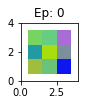

In [ ]:
# Lakukan training SOM dengan 3 fitur, tanpa import SOM
#from com.machinelearningnepal.som.batch_som import SOM
from matplotlib import pyplot as plt
from matplotlib import patches as patches
som = SOM(3,3,3) # panggil def __init__(self, net_x_dim, net_y_dim, num_features): # x_dim dan y_dim semacam set bentuk jaringan 3x3 = 9 neuron
init_fig = plt.figure()
som.show_plot(init_fig, 1, 0)
plt.show()

self.network_dimensions[0] =  3
self.network_dimensions[1] =  3


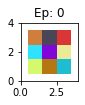

In [ ]:
# atau
# Lakukan training SOM dengan 3 fitur, dengan import SOM
#from com.algfromscratch.som.batch_som import SOM
from batch_som import SOM
from matplotlib import pyplot as plt
from matplotlib import patches as patches
som = SOM(3,3,3) # panggil def __init__(self, net_x_dim, net_y_dim, num_features): # x_dim dan y_dim semacam set bentuk jaringan 3x3 = 9 neuron
init_fig = plt.figure()
som.show_plot(init_fig, 1, 0)
plt.show()

In [ ]:
!pwd

/


In [ ]:
!echo $PYTHONPATH

/env/python


In [ ]:
# contoh
#os.environ['PYTHONPATH'] += ":/content/gdrive/My Drive/Colab Notebooks/MNIST_Classifier/src"
#!echo $PYTHONPATH

In [ ]:
#%set_env PYTHONPATH=/project/pylib/src:/env/python

In [ ]:
!echo $PYTHONPATH
#os.environ["PYTHONPATH"] = "/content/drive/My Drive/Master Big Data/com/algfromscratch/som/batch_som"
#os.environ["PYTHONPATH"] += ":/env/python"

#os.environ['PYTHONPATH'] = "/env/python"
#os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Master Big Data"

#os.environ['PYTHONPATH'] = ""
os.environ["PYTHONPATH"] = "/spark-2.4.1-bin-hadoop2.7/python/"
os.environ["PYTHONPATH"] += ":/spark-2.4.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip"
#os.environ["PYTHONPATH"] += ":/content/drive/My Drive/Master Big Data/com/algfromscratch/som"
#os.environ["PYTHONPATH"] += ":/content/drive/My Drive/Master Big Data/com/algfromscratch/som/batch_som.py"
os.environ["PYTHONPATH"] += ":/content/drive/'My Drive'/'Master Big Data'"
os.environ["PYTHONPATH"] += ":/env/python"


#export PYTHONPATH=$SPARK_HOME/python/:$PYTHONPATH
#export PYTHONPATH=$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$PYTHONPATH

#os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Master Big Data/com/algfromscratch/som"
#os.environ["PYTHONPATH"] += ":/content/drive/My Drive/Master Big Data/com/algfromscratch/som/"
#os.environ["PYTHONPATH"] += ":/content/drive/My Drive/Master Big Data/com/algfromscratch/som/batch_som"
#os.environ["PYTHONPATH"] += ":/content/drive/My Drive/Master Big Data/com/algfromscratch/som/batch_som/"
#os.environ["PYTHONPATH"] += ":/content/drive/'My Drive'/'Master Big Data'/com/algfromscratch/som"
#os.environ["PYTHONPATH"] += ":/content/drive/'My Drive'/'Master Big Data'/com/algfromscratch/som/"
#os.environ["PYTHONPATH"] += ":/content/drive/'My Drive'/'Master Big Data'/com/algfromscratch/som/batch_som"
#os.environ["PYTHONPATH"] += ":/content/drive/'My Drive'/'Master Big Data'/com/algfromscratch/som/batch_som/"


# content/drive/My Drive/Master Big Data/
#export PYTHONPATH=$PYTHONPATH:/path/to/som/lib
!echo $PYTHONPATH

/spark-2.4.1-bin-hadoop2.7/python/:/spark-2.4.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip:/content/drive/My Drive/Master Big Data:/env/python
/spark-2.4.1-bin-hadoop2.7/python/:/spark-2.4.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip:/content/drive/'My Drive'/'Master Big Data':/env/python


In [ ]:
#!ls $SPARK_HOME/yarn | sort | cut -d'-' -f 2

2.4.1


In [ ]:
#export SPARK_VERSION='ls /usr/local/Cellar/apache-spark/ | sort | tail -1'
#export SPARK_HOME="/usr/local/Cellar/apache-spark/$SPARK_VERSION/libexec"
#export PYTHONPATH=$SPARK_HOME/python/:$PYTHONPATH
#export PYTHONPATH=$SPARK_HOME/python/lib/py4j-0.10.7-src.zip:$PYTHONPATH

#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/spark-2.4.1-bin-hadoop2.7"
#os.environ["SPARK_VERSION"] = "!ls $SPARK_HOME/yarn | sort | cut -d'-' -f 2"
#!echo $SPARK_VERSION

!ls $SPARK_HOME/yarn | sort | cut -d'-' -f 2


In [ ]:
#import sys
#sys.path.extend(['/content/models/research/', '/content/models/research/slim/'])
#sys.path.extend(['/content/drive/My Drive/Master Big Data/com/algfromscratch/som/'])

In [ ]:
!pwd

/content/drive/My Drive/Master Big Data


In [ ]:
!ls ./com/algfromscratch/som

batch_som.py  __pycache__


In [ ]:
#%set_env PYTHONPATH=/content/drive/My Drive/Master Big Data/com/algfromscratch/som:/env/python

env: PYTHONPATH=/content/drive/My Drive/Master Big Data/com/algfromscratch/som:/env/python


In [ ]:
os.chdir("/")
!pwd
!ls

/
bin					   lib	  spark-2.4.1-bin-hadoop2.7
boot					   lib32  spark-2.4.1-bin-hadoop2.7.tgz
com					   lib64  srv
content					   media  swift
datalab					   mnt	  sys
dev					   opt	  tensorflow-1.15.2
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  proc   tmp
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   root   tools
etc					   run	  usr
home					   sbin   var


In [ ]:
!cp -r /content/drive/My\ Drive/Master\ Big\ Data/com /

In [ ]:
!chmod +x $SPARK_HOME/python/pyspark/com/algfromscratch/som/batch_som.py

In [ ]:
!python $SPARK_HOME/python/pyspark/com/algfromscratch/som/batch_som.py

In [ ]:
!echo $PYTHONPATH

:/env/python


In [ ]:
#!echo $PATH

/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin


In [ ]:
!pwd

/content/drive/My Drive/Master Big Data


In [ ]:
from com.algfromscratch.som.batch_som import SOM
som = SOM(5,5,3)


self.network_dimensions[0] =  5
self.network_dimensions[1] =  5


self.network_dimensions[0] =  5
self.network_dimensions[1] =  5


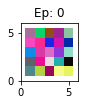

In [ ]:
#from batch_som import SOM
#from pyspark.com.algfromscratch.som.batch_som import SOM
from com.algfromscratch.som.batch_som import SOM
from matplotlib import pyplot as plt
from matplotlib import patches as patches
som = SOM(5,5,3) # panggil def __init__(self, net_x_dim, net_y_dim, num_features): # x_dim dan y_dim semacam set bentuk jaringan 3x3 = 9 neuron
init_fig = plt.figure()
som.show_plot(init_fig, 1, 0)
plt.show()

In [ ]:
scaledData.show(5)

+---------+-------+---------+-----+----------+-----+--------------------+
|  Year AD|Year BS|     Crop| Area|Production|Yield|            features|
+---------+-------+---------+-----+----------+-----+--------------------+
|2000/2001|2057/58|     JUTE|11289|     16392| 1452|[0.05928193709991...|
|  1993/94|2050/51|SUGARCANE|37785|   1293092|34222|[0.19842040865624...|
|  1992/93|2049/50|SUGARCANE|38330|   1365870|35634|[0.20128236770659...|
|  1991/92|2048/49|     JUTE|15000|     19000| 1267|[0.07876951514737...|
|  1996/97|2053/54|  TOBACCO| 5670|      4480|  790|[0.02977487672570...|
+---------+-------+---------+-----+----------+-----+--------------------+
only showing top 5 rows



In [ ]:
#from batch_som import SOM
from pyspark.com.algfromscratch.som.batch_som import SOM

self.network_dimensions[0] =  3
self.network_dimensions[1] =  3
SOM training epoches 2
neighborhood radius  2.6878753795222865
-------------------------------------
SOM training epoches 4
neighborhood radius  2.4082246852806923
-------------------------------------
SOM training epoches 6
neighborhood radius  2.157669279974593
-------------------------------------
SOM training epoches 8
neighborhood radius  1.9331820449317627
-------------------------------------
SOM training epoches 10
neighborhood radius  1.7320508075688772
-------------------------------------
SOM training epoches 12
neighborhood radius  1.5518455739153594
-------------------------------------
SOM training epoches 14
neighborhood radius  1.3903891703159093
-------------------------------------
SOM training epoches 16
neighborhood radius  1.2457309396155172
-------------------------------------
SOM training epoches 18
neighborhood radius  1.1161231740339044
-------------------------------------
SOM training epoches 20

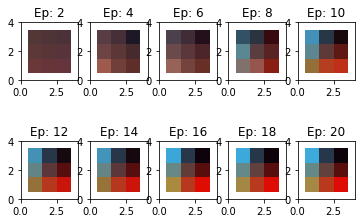

In [ ]:
# ini masih ngebug, solusinya gunakan yang bawah --> akhirnya berhasil [Solved]
# yaitu dengan mengcopykan folder "som" ke sistem "/" atau ke root :D
"""
import os
os.chdir("/")
!cp -r /content/drive/My\ Drive/Master\ Big\ Data/com /
"""

# Melakukan train scaledData dataframe yang memiliki kolom “features”.
# Dengan panggil lib From Scratch dari PYTHONPATH
from com.algfromscratch.som.batch_som import SOM
#from com.algfromscratch.som.batch_som import SOM
#from batch_som import SOM
#from matplotlib import pyplot as plt
#from matplotlib import patches as patches
som2 = SOM(3,3,3) # panggil def __init__(self, net_x_dim, net_y_dim, num_features): # x_dim dan y_dim semacam set bentuk jaringan 3x3 = 9 neuron
#init_fig = plt.figure()
#som.show_plot(init_fig, 1, 0)
#plt.show()
byk_epoch = 200 # byk iterasi

som2.train(scaledData, 20)
#som.train(scaledData,byk_epoch,False)

self.network_dimensions[0] =  3
self.network_dimensions[1] =  3
SOM training epoches 20
neighborhood radius  2.6878753795222865
-------------------------------------
SOM training epoches 40
neighborhood radius  2.4082246852806923
-------------------------------------
SOM training epoches 60
neighborhood radius  2.157669279974593
-------------------------------------
SOM training epoches 80
neighborhood radius  1.9331820449317627
-------------------------------------
SOM training epoches 100
neighborhood radius  1.7320508075688772
-------------------------------------
SOM training epoches 120
neighborhood radius  1.5518455739153598
-------------------------------------
SOM training epoches 140
neighborhood radius  1.3903891703159093
-------------------------------------
SOM training epoches 160
neighborhood radius  1.2457309396155174
-------------------------------------
SOM training epoches 180
neighborhood radius  1.1161231740339044
-------------------------------------
SOM training e

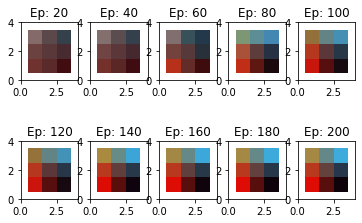

In [ ]:
# Ref Solusi Bug:
# https://stackoverflow.com/questions/56207920/how-to-add-the-path-to-pythonpath-in-google-colab

# Melakukan train scaledData dataframe yang memiliki kolom “features”. 
#from com.algfromscratch.som.batch_som import SOM
#import SOM
#from matplotlib import pyplot as plt
#from matplotlib import patches as patches
som = SOM(3,3,3) # panggil def __init__(self, net_x_dim, net_y_dim, num_features): # x_dim dan y_dim semacam set bentuk jaringan 3x3 = 9 neuron
#init_fig = plt.figure()
#som.show_plot(init_fig, 1, 0)
#plt.show()
byk_epoch = 200 # byk iterasi
som.train(scaledData, byk_epoch)

In [ ]:
# Melakukan prediksi untuk tiap input
prediction = som.predict(scaledData)
prediction.show()

+------+---------+----------+---------+-------+-----+--------------------+---------+--------------------+
|  Area|     Crop|Production|  Year AD|Year BS|Yield|                 bmu|  bmu_idx|            features|
+------+---------+----------+---------+-------+-----+--------------------+---------+--------------------+
| 11289|     JUTE|     16392|2000/2001|2057/58| 1452|[0.05566993808363...|[2.0,0.0]|[0.05928193709991...|
| 37785|SUGARCANE|   1293092|  1993/94|2050/51|34222|[0.23763045032189...|[2.0,2.0]|[0.19842040865624...|
| 38330|SUGARCANE|   1365870|  1992/93|2049/50|35634|[0.23763045032189...|[2.0,2.0]|[0.20128236770659...|
| 15000|     JUTE|     19000|  1991/92|2048/49| 1267|[0.05566993808363...|[2.0,0.0]|[0.07876951514737...|
|  5670|  TOBACCO|      4480|  1996/97|2053/54|  790|[0.05566993808363...|[2.0,0.0]|[0.02977487672570...|
| 12265|     JUTE|     15545|  1997/98|2054/55| 1267|[0.05566993808363...|[2.0,0.0]|[0.06440720688550...|
|  3597|  TOBACCO|      3460|2002/2003|2059/60

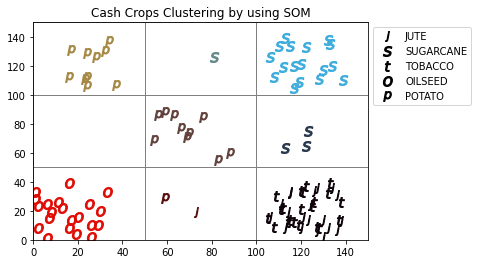

In [ ]:
# Memvisualisasikan cluster, agak kontra intuitif dalam ekosistem Big Data ketika 
# menggunakan dataframe.collect () karena semua data masuk ke node driver untuk penyederhanaan 
# visualisasi (untuk dataset kecil).

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111)
scale = 50
ax.set_xlim((0, som.net.shape[0]*scale))
ax.set_ylim((0, som.net.shape[1]*scale))
ax.set_title("Cash Crops Clustering by using SOM")

for x in range(0, som.net.shape[0]):
  for y in range(0, som.net.shape[1]):
    ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale, \
    facecolor='white', \
    edgecolor='grey'))
legend_map = {}

for row in prediction.collect():
  x_cor = row['bmu_idx'][0] * scale
  y_cor = row['bmu_idx'][1] * scale
  x_cor = np.random.randint(x_cor*1.05, (x_cor + scale*0.8))
  y_cor = np.random.randint(y_cor*1.05, (y_cor + scale*0.8))
  color = row['bmu']
  marker = "$\\ " + row['Crop'][0]+"$"
  marker = marker.lower()
  ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
  label = row['Crop']
  if not label in legend_map:
    legend_map[label] = mlines.Line2D([], [], color='black', marker=marker, linestyle='None', \
    markersize=10, label=label)
plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
#Done !

Semoga Sukses. Aamiin. :D
![]( https://docs.google.com/uc?export=download&id=1vJNmuncRehLc3WCZkFYCU6rRMVTy-w0k)